In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from jupyterthemes import jtplot
import pickle
import math
import statsmodels.formula.api as smf
import statsmodels
import scipy
import multiprocessing
from multiprocessing import Process, Queue, set_start_method, get_context
import time
import sys
#from cyStdDev import cStdDev, cStdDev_2D, glm, row_index, cSubtract
import os
import itertools
#from visualize_connectome_binary import plot_connectome
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib import cm
import matplotlib as mpl
import matplotlib.colors as mcol
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import preprocessing, decomposition, linear_model, metrics , feature_selection, model_selection, cross_decomposition, ensemble, tree, manifold, svm, neural_network 
from functools import reduce
from scipy import linalg
from scipy import stats
import sklearn

#from visualize_connectome import plot_connectome as plot_connectome_continuous

In [3]:
# np.random.seed(42)
jtplot.reset()
jtplot.reset()

const = 12
SMALL_SIZE = 8 + const  
MEDIUM_SIZE = 10 + const
BIGGER_SIZE = 12 + const

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=20)
np.core.arrayprint._line_width = 1000

In [4]:
pff_df = pd.read_csv('./pffScoutingData.csv')
pff_df.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [5]:
pff_df.pff_role.unique()

array(['Pass', 'Pass Route', 'Pass Block', 'Pass Rush', 'Coverage'],
      dtype=object)

In [6]:
pff_df.pff_hit.sum() + pff_df.pff_hurry.sum() + pff_df.pff_sack.sum()

4322.0

In [7]:
plays_df.passResult.value_counts()

NameError: name 'plays_df' is not defined

In [8]:
plays_df = pd.read_csv('./plays.csv')
plays_df.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,13:18,0,0,C,NaN,28,28,NaN,NaN,NaN,NaN,NaN,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,12:23,0,0,C,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,09:56,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,09:46,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone


In [118]:
plays_df.absoluteYardlineNumber.min()

11.0

In [9]:
players_df = pd.read_csv('./players.csv')
players_df.head()

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,28963,6-5,240,1982-03-02,"Miami, O.",QB,Ben Roethlisberger
2,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
3,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
4,30078,6-2,228,1982-11-24,Harvard,QB,Ryan Fitzpatrick


In [10]:
off_groupings = [['QB', 'RB', 'FB'], ['G', 'C', 'T'], ['TE', 'WR']]
def_groupings = [['DE', 'NT', 'DT'], ['OLB', 'MLB', 'ILB', 'LB'], ['SS', 'FS', 'CB', 'DB']]

assert len([a for b in off_groupings for a in b] + [a for b in def_groupings for a in b]) == len(players_df.officialPosition.unique())

In [11]:
#import nilearn
#from nilearn.connectome import ConnectivityMeasure
#connectivity = nilearn.connectome.ConnectivityMeasure(kind='partial correlation', vectorize=False, discard_diagonal=False)
#partial_connectome = connectivity.fit_transform([off_play_data[['x', 'y']].values.T])

In [13]:
def get_conn_data(week_df, plays_df, game_id, play_id):
    n_frames_keep = 20

    play_info = plays_df[(plays_df.playId == play_id) & (plays_df.gameId == game_id)]
    off_team = play_info.possessionTeam.values.flatten()[0]
    def_team = play_info.defensiveTeam.values.flatten()[0]

    play_data = week_df[week_df.playId == play_id].copy()
    if 'ball_snap' not in play_data.event.values:
        raise Exception()

    bal_play_data = play_data[(play_data.team == 'football') & (play_data.event == 'ball_snap')].sort_values(by=['frameId'])
    bal_x = bal_play_data['x'].values[0]
    bal_y = bal_play_data['y'].values[0]
    play_data['x'] = (play_data['x'] - bal_x) / x_max
    play_data['y'] = (play_data['y'] - bal_y) / y_max
    play_data['o'] = play_data['o'] / 360
    play_data['dir'] = play_data['dir'] / 360

    ball_play_data_scaled = bal_play_data.copy()
    ball_play_data_scaled['x'] = (ball_play_data_scaled['x'] - x_min) / (x_max - x_min)
    ball_play_data_scaled['y'] = (ball_play_data_scaled['y'] - y_min) / (y_max - y_min)

    off_snap_frame = np.unique(play_data[(play_data.team == off_team) & (play_data.event == 'ball_snap')].frameId.values)
    assert len(off_snap_frame) == 1
    off_play_data = play_data[(play_data.team == off_team) & (play_data.frameId >= off_snap_frame[0]) & (play_data.frameId < (off_snap_frame[0] + n_frames_keep))]
    off_players = np.unique(off_play_data.nflId.values)

    def_snap_frame = np.unique(play_data[(play_data.team == def_team) & (play_data.event == 'ball_snap')].frameId.values)
    assert len(def_snap_frame) == 1
    def_play_data = play_data[(play_data.team == def_team) & (play_data.frameId >= def_snap_frame[0]) & (play_data.frameId < (def_snap_frame[0] + n_frames_keep))]
    def_players = np.unique(def_play_data.nflId.values)

    features_of_interest = ['x', 'y', 's', 'a', 'dis', 'o', 'dir']
    ts_features = np.zeros((n_frames_keep, 22, len(features_of_interest)))
    connectomes = np.zeros((22, 22, len(features_of_interest)))
    for feature_i, feature in enumerate(features_of_interest):
        off_feature_vals = off_play_data.pivot(index='frameId', columns='nflId', values=feature)[off_players].values
        def_feature_vals = def_play_data.pivot(index='frameId', columns='nflId', values=feature)[def_players].values
        off_def_features = np.concatenate((off_feature_vals, def_feature_vals), axis=1)
        conn = connectivity.fit_transform([off_def_features])[0, :, :]
        ts_features[:, :, feature_i] = off_def_features
        connectomes[:, :, feature_i] = conn
        
    player_features = np.concatenate((off_players, def_players))
    return ts_features, connectomes, player_features

In [ ]:
week_df = pd.read_csv(f'./week1.csv')  # all teams play in week 1
team_dummies = pd.get_dummies(week_df['team'].unique())
teams = team_dummies.columns.values
team_embed = team_dummies.values

x_min = 0
x_max = 120
y_min = 0
y_max = 54

In [281]:
def pairwise_inv_delta(a):
    n = a.shape[0]
    a = scipy.stats.zscore(a, axis=0)
    i, j = np.triu_indices(n, k=1)
    diff = 1 / np.square(a[i] - a[j])  # np.square(a[i] - a[j])
    result = np.zeros((n, n))
    result[i,j] = diff
    result = result + result.T
    np.fill_diagonal(result, 0)
    return np.nan_to_num(result, nan=1, posinf=1, neginf=1)

def pairwise_prod(a):
    n = a.shape[0]
    a = scipy.stats.zscore(a, axis=0)
    i, j = np.triu_indices(n, k=1)
    diff = (a[i] * a[j])
    result = np.zeros((n, n))
    result[i,j] = diff
    result = result + result.T
    return np.nan_to_num(result, nan=1, posinf=1, neginf=1)

In [282]:
def get_ts_data(week_df, plays_df, game_id, play_id):
    n_frames_keep = 20

    play_info = plays_df[(plays_df.playId == play_id) & (plays_df.gameId == game_id)]
    if play_info[['foulName1', 'foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3']].isna().sum(1).values[0] != 6:
        return None
    
    off_team = play_info.possessionTeam.values.flatten()[0]
    def_team = play_info.defensiveTeam.values.flatten()[0]

    play_data = week_df[week_df.playId == play_id].copy()
    if 'ball_snap' not in play_data.event.values:
        return None

    bal_play_data = play_data[(play_data.team == 'football') & (play_data.event == 'ball_snap')].sort_values(by=['frameId'])
    bal_x = bal_play_data['x'].values[0]
    bal_y = bal_play_data['y'].values[0]
    play_data['x'] = (play_data['x'] - bal_x)
    play_data['y'] = (play_data['y'] - bal_y)
    play_data['o'] = play_data['o'] / 360
    play_data['dir'] = play_data['dir'] / 360

    ball_play_data_scaled = bal_play_data.copy()
    ball_play_data_scaled['x'] = (ball_play_data_scaled['x'] - x_min) / (x_max - x_min)
    ball_play_data_scaled['y'] = (ball_play_data_scaled['y'] - y_min) / (y_max - y_min)

    off_snap_frame = np.unique(play_data[(play_data.team == off_team) & (play_data.event == 'ball_snap')].frameId.values)
    assert len(off_snap_frame) == 1
    off_play_data = play_data[(play_data.team == off_team) & (play_data.frameId >= off_snap_frame[0]) & (play_data.frameId < (off_snap_frame[0] + n_frames_keep))]
    off_players = np.unique(off_play_data.nflId.values)

    def_snap_frame = np.unique(play_data[(play_data.team == def_team) & (play_data.event == 'ball_snap')].frameId.values)
    assert len(def_snap_frame) == 1
    def_play_data = play_data[(play_data.team == def_team) & (play_data.frameId >= def_snap_frame[0]) & (play_data.frameId < (def_snap_frame[0] + n_frames_keep))]
    def_players = np.unique(def_play_data.nflId.values)
    
    assert off_play_data.shape[0] == def_play_data.shape[0]
    n_frames = int(int(off_play_data.shape[0]/11))
    assert n_frames - off_play_data.shape[0]/11 == 0
    if n_frames != n_frames_keep:
        return None
    
    x_scale = 1
    if (off_play_data.playDirection.unique()[0] != 'right'):
        x_scale = -1
    
    features_of_interest = ['x', 'y']  #, 's', 'a', 'dis', 'o', 'dir']
    ts_features = np.zeros((n_frames, 22, len(features_of_interest) + 7), dtype=np.float32)
    delta_features = np.zeros((n_frames, 22, 22, len(features_of_interest)), dtype=np.float32)
    r_features = np.zeros((n_frames, 22, 22, len(features_of_interest)), dtype=np.float32)
    for feature_i, feature in enumerate(features_of_interest):
        off_feature_vals = off_play_data.pivot(index='frameId', columns='nflId', values=feature)[off_players].values
        def_feature_vals = def_play_data.pivot(index='frameId', columns='nflId', values=feature)[def_players].values
        if feature == 'x':
            off_feature_vals *= x_scale
            def_feature_vals *= x_scale
        off_def_features = np.concatenate((off_feature_vals, def_feature_vals), axis=1)
        ts_features[:, :, feature_i] = scipy.stats.zscore(off_def_features)
        delta_features[:, :, :, feature_i] = np.apply_along_axis(pairwise_inv_delta, axis=1, arr=off_def_features)
        r_features[:, :, :, feature_i] = np.apply_along_axis(pairwise_prod, axis=1, arr=off_def_features)
    
    ts_features[:, :, len(features_of_interest) + 0] = np.repeat(np.arange(n_frames_keep).reshape(-1, 1), 22, axis=1)*0.1
    ts_features[:, :, len(features_of_interest) + 1] = np.repeat(np.concatenate((np.ones(11), np.zeros(11))).reshape(1, -1), n_frames_keep, axis=0)
    ts_features[:, :, len(features_of_interest) + 2] = play_info.quarter.values.flatten()[0] / 4
    ts_features[:, :, len(features_of_interest) + 3] = play_info.down.values.flatten()[0] / 3
    ts_features[:, :, len(features_of_interest) + 4] = play_info.yardsToGo.values.flatten()[0] / 10
    ts_features[:, :, len(features_of_interest) + 5] = play_info.absoluteYardlineNumber.fillna(49.0).values.flatten()[0] / x_max
    play_time = play_info.gameClock.values.flatten()[0]
    play_time_m, play_time_s = play_time.split(':')
    ts_features[:, :, len(features_of_interest) + 6] = (int(play_time_m)*60 + int(play_time_s)) / 900    
    
    
    player_features = np.concatenate((off_players, def_players)).astype(np.float32)
    return ts_features, delta_features, r_features, player_features

In [283]:
res = []
for week_i in tqdm(range(1, 9), ncols=1000, leave=True):
    week_df = pd.read_csv(f'./week{week_i}.csv')
    for game in tqdm(week_df.gameId.unique(), ncols=1000, leave=False):
        week_game_df = week_df[week_df.gameId == game]
        #week_game_df = week_game_df.dropna(subset=['nflId'])
        for play_id in tqdm(week_game_df.playId.unique(), ncols=1000, leave=False):
            if len(week_game_df[week_game_df.playId==play_id].nflId.unique()) != 23: 
                n_players_bad = len(week_game_df[week_game_df.playId==play_id].nflId.unique())
                print(f'skipping: {game} {play_id}... {n_players_bad} players')
                continue
            snap_output = get_ts_data(week_game_df, plays_df, game, play_id)
            if snap_output is None: continue
            ts_features, delta_features, r_features, player_features = snap_output
            res.append((ts_features, delta_features, r_features, player_features, game, play_id))
            
pickle.dump(res, open('./ts_player_features_game_playid.pickle', 'wb'))

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

/nfs/corenfs/psych-freewill-data/Users/ataxali/conda/sripada_lab/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [396]:
def get_snap_mat(week_df, plays_df, game_id, play_id):
    play_info = plays_df[(plays_df.playId == play_id) & (plays_df.gameId == game_id)]
    off_team = play_info.possessionTeam.values.flatten()[0]
    def_team = play_info.defensiveTeam.values.flatten()[0]

    play_data = week_df[week_df.playId == play_id].copy()
    if 'ball_snap' not in play_data.event.values:
        return None
    
    play_data['o'] = play_data['o'] / 360
    play_data['dir'] = play_data['dir'] / 360
    off_play_data = play_data[(play_data.team == off_team) & (play_data.event == 'ball_snap')].sort_values(by=['jerseyNumber', 'frameId'])
    def_play_data = play_data[(play_data.team == def_team) & (play_data.event == 'ball_snap')].sort_values(by=['jerseyNumber', 'frameId'])
    bal_play_data = play_data[(play_data.team == 'football') & (play_data.event == 'ball_snap')].sort_values(by=['frameId'])
    bal_x = bal_play_data['x'].values[0]
    bal_y = bal_play_data['y'].values[0]
    assert (not math.isnan(bal_x))
    assert (not math.isnan(bal_y))
    off_play_data['x'] = off_play_data['x'] - bal_x
    off_play_data['y'] = off_play_data['y'] - bal_y
    def_play_data['x'] = def_play_data['x'] - bal_x
    def_play_data['y'] = def_play_data['y'] - bal_y
    
    ball_play_data_scaled = bal_play_data.copy()
    ball_play_data_scaled['s'] = 0
    ball_play_data_scaled['dis'] = 0
    ball_play_data_scaled['o'] = 0
    ball_play_data_scaled['dir'] = 0
    ball_play_data_scaled['x'] = (ball_play_data_scaled['x'] - x_min) / (x_max - x_min)
    ball_play_data_scaled['y'] = (ball_play_data_scaled['y'] - y_min) / (y_max - y_min)
    bal_play_data['x'] = bal_play_data['x'] - bal_x
    bal_play_data['y'] = bal_play_data['y'] - bal_y

    # X = n_samples_X, n_features
    dist_mat = sklearn.metrics.pairwise.euclidean_distances(np.concatenate((off_play_data[['x', 'y']].values, 
                                                                            def_play_data[['x', 'y']].values,
                                                                            bal_play_data[['x', 'y']].values), axis=0))
    np.fill_diagonal(dist_mat, 1)
    dist_mat = np.square(1 / dist_mat)
    np.fill_diagonal(dist_mat, 0)
    ###
    off_player_features = off_play_data[['nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']].values
    off_team_features = np.repeat(np.atleast_2d(team_embed[:, np.argwhere(teams == off_team).flatten()[0]]), 
                                  repeats=off_player_features.shape[0], axis=0)
    off_player_features = np.concatenate((off_player_features, off_team_features), axis=1)
    ###
    def_player_features = def_play_data[['nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']].values
    def_team_features = np.repeat(np.atleast_2d(team_embed[:, np.argwhere(teams == def_team).flatten()[0]]), 
                                  repeats=def_player_features.shape[0], axis=0)
    def_player_features = np.concatenate((def_player_features, def_team_features), axis=1)
    ###
    ball_features = ball_play_data_scaled[['nflId', 'x', 'y', 's', 'a', 'dis', 'o', 'dir']].fillna(0)
    ball_team_features = np.repeat(np.atleast_2d(team_embed[:, np.argwhere(teams == 'football').flatten()[0]]), 
                                   repeats=ball_features.shape[0], axis=0)
    ball_features = np.concatenate((ball_features, ball_team_features), axis=1)

    player_features = np.concatenate((off_player_features, 
                                      def_player_features,
                                      ball_features), axis=0)
    return dist_mat, player_features

In [182]:
pff_df.head()

,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock
0,2021090900,97,25511,Pass,QB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021090900,97,35481,Pass Route,TE-L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021090900,97,35634,Pass Route,LWR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021090900,97,39985,Pass Route,HB-R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021090900,97,40151,Pass Block,C,NaN,NaN,NaN,0.0,0.0,0.0,0.0,44955.0,SW,0.0


In [258]:
def get_frame_conn(week_df, plays_df, game_id, play_id, frame_offset):
    #week_df, plays_df, game_id, play_id = (week_game_df, plays_df, game, play_id)
    #frame_offset = 0

    play_info = plays_df[(plays_df.playId == play_id) & (plays_df.gameId == game_id)]
    off_team = play_info.possessionTeam.values.flatten()[0]
    def_team = play_info.defensiveTeam.values.flatten()[0]

    if play_info[['foulName1', 'foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3']].isna().sum(1).values[0] != 6:
        return None

    play_data = week_df[week_df.playId == play_id].copy()
    if 'ball_snap' not in play_data.event.values:
        return None

    bal_play_data = play_data[(play_data.team == 'football') & (play_data.event == 'ball_snap')].sort_values(by=['frameId'])
    bal_x = bal_play_data['x'].values[0]
    bal_y = bal_play_data['y'].values[0]
    assert (not math.isnan(bal_x))
    assert (not math.isnan(bal_y))

    play_data = pd.concat((play_data[play_data.team == off_team], play_data[play_data.team == def_team]))

    snap_frame = bal_play_data.frameId.values[0]
    play_data = play_data[play_data.frameId == snap_frame + frame_offset]
    play_data['x'] = play_data['x'] - bal_x
    play_data['y'] = play_data['y'] - bal_y
    play_data['o'] = play_data['o'] / 360
    play_data['dir'] = play_data['dir'] / 360
    if play_data.shape[0] != 22:
        return None

    play_data = play_data.merge(pff_df[['gameId', 'playId', 'nflId', 'pff_positionLinedUp', 'pff_role', 'pff_nflIdBlockedPlayer']])
    dist_mat = 1/sklearn.metrics.pairwise.euclidean_distances(play_data[['x', 'y']].values)
    dist_mat = np.nan_to_num(dist_mat, nan=1, posinf=1, neginf=1)

    bin_mat = np.zeros((22, 22))
    for player_i in range(play_data.shape[0]):
        player_i_block_id = play_data.pff_nflIdBlockedPlayer.values[player_i]
        if not math.isnan(player_i_block_id):
            if len(np.argwhere(play_data.nflId.values == player_i_block_id).flatten()) != 0:
                player_i_block_idx = np.argwhere(play_data.nflId.values == player_i_block_id).flatten()[0]
                bin_mat[player_i, player_i_block_idx] = 1
        qb_idx = np.argwhere(play_data.pff_positionLinedUp.values == 'QB').flatten()[0]
        if play_data.pff_role.values[player_i] == 'Pass Rush':
            bin_mat[player_i, qb_idx] = 1

    bin_mat += bin_mat.T
    bin_mat = np.clip(bin_mat, 0, 1)
    player_features = play_data.nflId.values.reshape(-1, 1)

    knn_mat = np.zeros((22, 22))
    for player_i in range(dist_mat.shape[0]):
        player_sims = dist_mat[player_i, :].copy()
        player_sims[player_i] = 0
        closest_neigh = np.argsort(np.abs(player_sims))[::-1][0:2]
        knn_mat[player_i, closest_neigh] = 1
        
    return dist_mat, bin_mat, knn_mat, player_features

In [259]:
import warnings
for frame_offset in [5, 10, 15, 20]:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        res = []
        for week_i in tqdm(range(1, 9), ncols=1000, leave=True):
            week_df = pd.read_csv(f'./week{week_i}.csv')
            for game in tqdm(week_df.gameId.unique(), ncols=1000, leave=False):
                week_game_df = week_df[week_df.gameId == game]
                #week_game_df = week_game_df.dropna(subset=['nflId'])
                for play_id in tqdm(week_game_df.playId.unique(), ncols=1000, leave=False):
                    if len(week_game_df[week_game_df.playId==play_id].nflId.unique()) != 23: 
                        n_players_bad = len(week_game_df[week_game_df.playId==play_id].nflId.unique())
                        print(f'skipping: {game} {play_id}... {n_players_bad} players')
                        continue
                    snap_output = get_frame_conn(week_game_df, plays_df, game, play_id, frame_offset=frame_offset)
                    if snap_output is None: continue
                    dist_mat, bin_mat, knn_mat, player_features = snap_output
                    res.append((dist_mat, bin_mat, knn_mat, player_features, game, play_id))

        pickle.dump(res, open(f'./static_mats_offset_{frame_offset}.pickle', 'wb'))

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [260]:
len(res)

7751

In [335]:
utri_idxs = np.triu_indices(n=22, k=1)
FEATURES_OF_INTEREST = ['x', 'y', 's', 'a', 'dis'] #, 'o', 'dir']

def get_corr_mat(week_df, plays_df, game_id, play_id):
    play_info = plays_df[(plays_df.playId == play_id) & (plays_df.gameId == game_id)]
    off_team = play_info.possessionTeam.values.flatten()[0]
    def_team = play_info.defensiveTeam.values.flatten()[0]

    play_data = week_df[week_df.playId == play_id]
    off_play_data = play_data[play_data.team == off_team].sort_values(by=['jerseyNumber', 'frameId'])
    def_play_data = play_data[play_data.team == def_team].sort_values(by=['jerseyNumber', 'frameId'])
    
    corr_mats = []
    for feature in FEATURES_OF_INTEREST:
        off_data = off_play_data[['frameId', 'jerseyNumber', feature]].pivot(index='frameId', columns='jerseyNumber', values=feature).values
        def_data = def_play_data[['frameId', 'jerseyNumber', feature]].pivot(index='frameId', columns='jerseyNumber', values=feature).values
        corr_mat = np.corrcoef(np.hstack((off_data, def_data)).T)
        corr_mats.append(corr_mat)
        
    player_ids = np.concatenate((off_play_data.nflId.unique(),
                                 def_play_data.nflId.unique()))
    corr_mat = np.swapaxes(np.array(corr_mats), 0, 2)
    return corr_mat[utri_idxs[0], utri_idxs[1], :], player_ids

In [228]:
res = []
for week_i in tqdm(range(1, 9), ncols=1000, leave=True):
    week_df = pd.read_csv(f'./week{week_i}.csv')
    for game in tqdm(week_df.gameId.unique(), ncols=1000, leave=False):
        week_game_df = week_df[week_df.gameId == game]
        week_game_df = week_game_df.dropna(subset=['nflId'])
        for play_id in tqdm(week_game_df.playId.unique(), ncols=1000, leave=False):
            if len(week_game_df[week_game_df.playId==play_id].nflId.unique()) != 22: 
                n_players_bad = len(week_game_df[week_game_df.playId==play_id].nflId.unique())
                print(f'skipping: {game} {play_id}... {n_players_bad} players')
                continue
            corr_mat, player_ids = get_corr_mat(week_game_df, plays_df, game, play_id)
            res.append((corr_mat, player_ids, game, play_id))

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [230]:
pickle.dump(res, open('./corrmat_playerids_game_playid.pickle', 'wb'))

In [167]:
corr_mat_utri, player_ids = get_corr_mat(week_1_df, plays_df, play_id=97)
corr_mat = np.zeros((22, 22, corr_mat_utri.shape[1]))
corr_mat[utri_idxs[0], utri_idxs[1], :] = corr_mat_utri
corr_mat += np.swapaxes(corr_mat, 0, 1)

In [128]:
temp_df = pd.DataFrame()
temp_df['nflId'] = player_ids
temp_df = temp_df.merge(players_df[['nflId', 'officialPosition']])
player_positions = temp_df.officialPosition.values.flatten()

new_order_idxs = []
group_sizes = []
for group in off_groupings + def_groupings:
    pos_size = 0
    for pos in group:
        pos_idxs = np.argwhere(player_positions == pos).flatten()
        new_order_idxs.extend(pos_idxs)
        pos_size += len(pos_idxs)
    group_sizes.append(pos_size)

assert len(new_order_idxs) == 22
assert len(np.unique(new_order_idxs)) == 22

In [155]:
np.array(list(zip(player_ids, player_positions)))[new_order_idxs]

array([['25511.0', 'QB'],
       ['39985.0', 'RB'],
       ['46163.0', 'G'],
       ['42404.0', 'G'],
       ['40151.0', 'C'],
       ['42377.0', 'T'],
       ['52421.0', 'T'],
       ['35481.0', 'TE'],
       ['41233.0', 'WR'],
       ['44896.0', 'WR'],
       ['35634.0', 'WR'],
       ['41263.0', 'DE'],
       ['44955.0', 'DE'],
       ['42403.0', 'DE'],
       ['53504.0', 'DT'],
       ['53441.0', 'OLB'],
       ['43306.0', 'MLB'],
       ['47996.0', 'SS'],
       ['44962.0', 'SS'],
       ['52459.0', 'CB'],
       ['44904.0', 'CB'],
       ['43478.0', 'CB']], dtype='<U32')

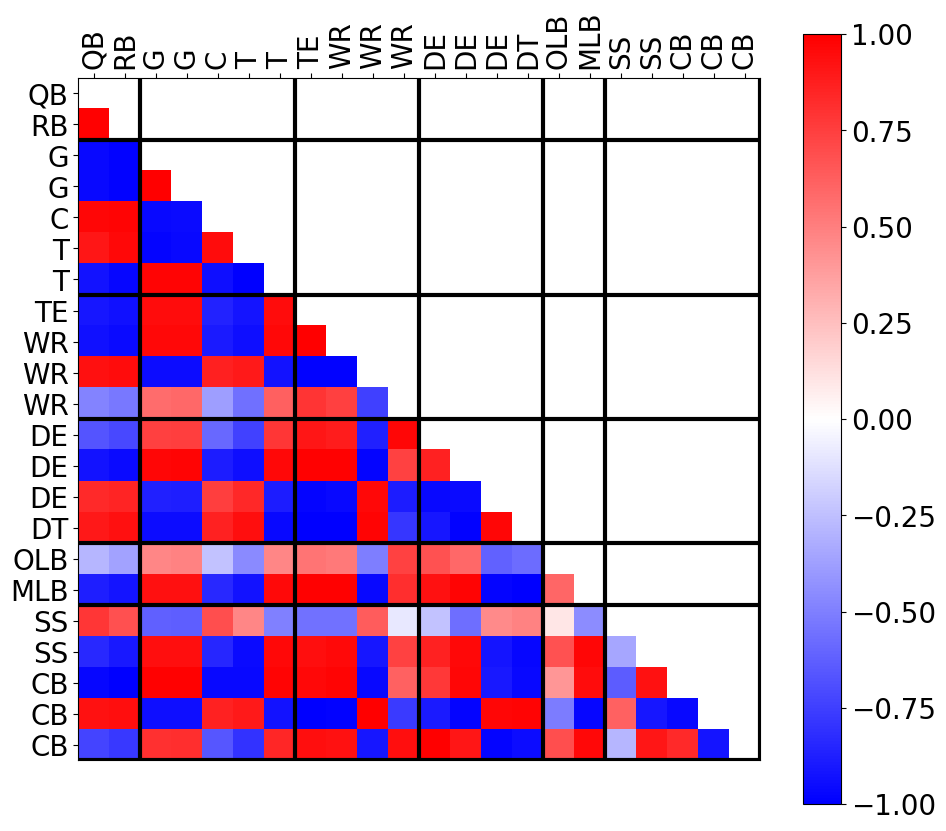

In [154]:
plt.figure(figsize=(11, 10))
plot_mat = corr_mat[:, :, 1]
plot_mat = plot_mat[new_order_idxs, :][:, new_order_idxs]
plot_mat[np.triu_indices(n=22, k=0)] = np.float32('nan')

plt.imshow(plot_mat, vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.yticks(np.arange(len(player_positions)), player_positions[new_order_idxs])
plt.xticks(np.arange(len(player_positions)), player_positions[new_order_idxs], rotation=90)

offset = 0.5
curr_idx = 0
for group_size in group_sizes:
    curr_idx += group_size
    plt.plot([-0.5, 21.5], [curr_idx-offset, curr_idx-offset], c='k', linewidth=3)
    plt.plot([curr_idx-offset, curr_idx-offset], [-0.5, 21.5], c='k', linewidth=3)
    
plt.gca().xaxis.tick_top()
plt.show()

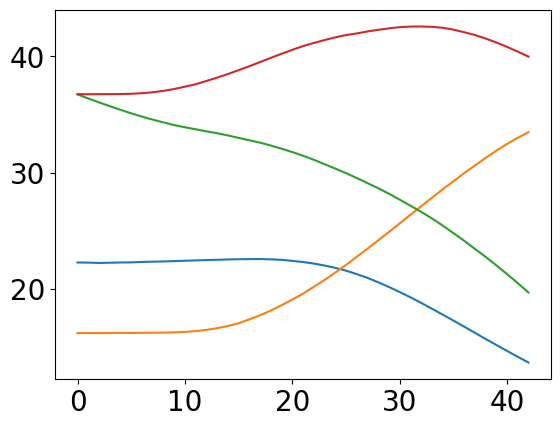

In [175]:
all_x_vals = []

x_val = week_1_df[(week_1_df.gameId==2021090900) & (week_1_df.nflId == 39985) & 
                  (week_1_df.playId == 97)].y.values
plt.plot(np.arange(len(x_val)), x_val)
all_x_vals.append(x_val)

x_val = week_1_df[(week_1_df.gameId==2021090900) & (week_1_df.nflId == 41233) & 
                  (week_1_df.playId == 97)].y.values
plt.plot(np.arange(len(x_val)), x_val)
all_x_vals.append(x_val)

x_val = week_1_df[(week_1_df.gameId==2021090900) & (week_1_df.nflId == 44896) & 
                  (week_1_df.playId == 97)].y.values
plt.plot(np.arange(len(x_val)), x_val)
all_x_vals.append(x_val)

x_val = week_1_df[(week_1_df.gameId==2021090900) & (week_1_df.nflId == 35634) & 
                  (week_1_df.playId == 97)].y.values
plt.plot(np.arange(len(x_val)), x_val)
all_x_vals.append(x_val)

plt.show()

In [178]:
np.corrcoef(np.array(all_x_vals))

array([[ 1.        , -0.95806824,  0.94626623, -0.53026122],
       [-0.95806824,  1.        , -0.98686354,  0.74934126],
       [ 0.94626623, -0.98686354,  1.        , -0.74596102],
       [-0.53026122,  0.74934126, -0.74596102,  1.        ]])

In [153]:
players_df[players_df.nflId == 41233]

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName
198,41233,6-5,231,1993-08-21,Texas A&amp;M,WR,Mike Evans


In [3]:
week_1_df = pd.read_csv('./week1.csv')
week_1_df.head()

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


In [5]:
week_1_df.head(50)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None
5,2021090900,97,25511.0,6,2021-09-10T00:26:31.600,12.0,TB,right,37.64,24.26,0.35,0.53,0.05,144.42,282.72,ball_snap
6,2021090900,97,25511.0,7,2021-09-10T00:26:31.700,12.0,TB,right,37.56,24.26,0.54,1.05,0.08,137.49,272.95,None
7,2021090900,97,25511.0,8,2021-09-10T00:26:31.800,12.0,TB,right,37.47,24.25,0.80,1.85,0.09,131.95,267.49,None
8,2021090900,97,25511.0,9,2021-09-10T00:26:31.900,12.0,TB,right,37.38,24.24,0.99,2.03,0.09,129.85,263.48,None
9,2021090900,97,25511.0,10,2021-09-10T00:26:32.000,12.0,TB,right,37.27,24.23,1.19,1.82,0.11,123.79,263.77,None


In [4]:
week_1_df.event.unique()

array(['None', 'ball_snap', 'autoevent_passforward', 'pass_forward',
       'autoevent_ballsnap', 'line_set', 'play_action', 'pass_arrived',
       'autoevent_passinterrupted', 'fumble', 'fumble_offense_recovered',
       'qb_sack', 'run', 'man_in_motion', 'pass_outcome_caught',
       'pass_outcome_incomplete', 'pass_tipped', 'qb_strip_sack', 'shift',
       'first_contact', 'huddle_break_offense', 'lateral', 'handoff'],
      dtype=object)

In [5]:
week_1_df.shape

(1118122, 16)